In [1]:
# %%
# import cbpro
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
import numpy as np
df = pd.read_csv('/Users/qyu/Desktop/hbu_analytics/BTC_minute_bar.csv',index_col=0)

In [2]:
df.head()

,date,sym,datetime,open,high,low,close,volume
0,2018-01-01,BTCUSD,2018-01-01 00:00:00,13863.1400,13885.3400,13863.1300,13863.7800,3.2290
1,2018-01-01,BTCUSD,2018-01-01 00:01:00,13869.6500,13879.7300,13861.0000,13879.7300,5.4977
2,2018-01-01,BTCUSD,2018-01-01 00:02:00,13879.7400,13879.7400,13852.0000,13852.0000,12.1362
3,2018-01-01,BTCUSD,2018-01-01 00:03:00,13852.0100,13852.0100,13810.0000,13822.3900,23.2947
4,2018-01-01,BTCUSD,2018-01-01 00:04:00,13822.3900,13822.3900,13803.0000,13803.0000,9.7976


In [3]:
import statsmodels.api as sm

class MarkovAR:
    
    def __init__(self, ts, lag, k, dr=True):
        '''
        ts : time series of your input data, type: pandas.series
        lag : the lag order in Auto Regression 
        k : number of regimes in the Markov Chain
        dr : bool, whether the slope coefficient vary across the regimes
        '''
        self.ts = ts
        self.lag = lag
        self.k = k
        self.dr = dr
    
    def fit(self):
        m = sm.tsa.MarkovRegression(endog = self.ts, k_regimes = self.k, order = self.lag, trend='n', switching_variance = True)
        self.res = m.fit()
        return self
    
    def get_smooth_prob(self, keep_all=False):
        '''
        keep_all : bool, whether to keep nan values in the smoothed probability dataframe
        '''
        df_p = pd.DataFrame()
        for i in range(self.k):
            df_p[f'Regime{i}'] = self.res.smoothed_marginal_probabilities[i]
        df_p['regime'] = df_p.idxmax(axis=1)
        if not keep_all:
            df_p = df_p.dropna()
        return df_p
    
    def get_transition_prob_mat(self):
        '''
        # Extracting the transition probabilities to form the transition matrix
        k : number of regimes
        res : fit result of the MSA (Markov Swithcing Autoregression) model
        '''
        transition_matrix = []
        
        # For each regime, extract the transition probabilities to other regimes
        for i in range(self.k):
            current_row = []
            for j in range(self.k):
                key = f'p[{i}->{j}]'
                if key in self.res.params:
                    current_row.append(self.res.params[key])
                else:
                    # If the probability is not directly provided, deduce it
                    current_row.append(1 - sum(current_row))
            transition_matrix.append(current_row)
        
        transition_matrix_df = pd.DataFrame(transition_matrix, columns=[f'To Regime{n}' for n in range(self.k)], index=[f'From Regime{n}' for n in range(self.k)])
        return transition_matrix_df
        

In [4]:
# please do liquidity analysis here
# the liquidity is defined as the ratio of the 30 minute rolling standard deviation of price return (close - open) / open to the volume
# calculate the liquidity
data = df.copy()
data['liquidity'] = data['close'].rolling(30).std() / data['volume']
# drop the data where the liquidity is nan
data.dropna(inplace=True)

# calculate the rolling z score of liquidity
data['liquidity_z_score'] = (data['liquidity'] - data['liquidity'].rolling(30).mean()) / data['liquidity'].rolling(30).std()
# drop the data where the liquidity z score is nan
data.dropna(inplace=True)

# apply the regine change method to find the regime change points
# smooth the rolling z score of liquidity by using the rolling median
data['liquidity_z_score'] = data['liquidity_z_score'].rolling(5).median()
data.dropna(inplace=True)

In [5]:
# # construct a df_input with columns liquidity_z_score and index datetime
# df_input = data.copy().set_index(['datetime'])['liquidity_z_score'][:200000]
# mar = MarkovAR(df_input, 1, 3, True).fit()
# # print(mar.res.summary())
# df_p = mar.get_smooth_prob()
# df_p.head()

In [97]:
def cross_over(px, n, m, n_vol=1440, bEWMAVol=True, bNormalization=True):
    """
    calculate trend that can be used for vol timing
    """    
    a = 1 - 1 / n 
    b = 1 - 1 / m
    C = np.sqrt(1 / (1 - a**2) + 1 / (1 - b**2) - 2 / (1 - a * b)) if bNormalization else 1
    
    hl1 = np.log(0.5) / np.log(a)
    hl2 = np.log(0.5) / np.log(b)
    
    signal = px.ewm(halflife=hl1).mean() - px.ewm(halflife=hl2).mean()
    
    vol_a = 1 - 1/n_vol
    vol_hl = np.log(0.5) / np.log(vol_a)
    
    if bEWMAVol: 
        rolling_vol = (px - px.shift(1)).ewm(halflife=vol_hl, min_periods=int(n_vol * 0.8)).std()
    else:
        rolling_vol = (px - px.shift(1)).rolling(n_vol, min_periods=int(n_vol * 0.8)).std()
    
    signal = signal / rolling_vol
    signal_adj = signal / C
    return signal_adj

def cal_max_dd(data):
    cum_max = data.cummax()
    drawdown = data - cum_max
    max_drawdown = drawdown.min()
    return max_drawdown
    
def mini_backtest(df_input, prediction):
    df = df_input.copy()
    avg_abs_pos = df['POS'].abs().mean()
    gross_return = df[prediction].mean() * 100 * 252 * 60 * 24
    net_return = (df[prediction] - df['TC']).mean() * 100 * 252 * 60 * 24
    vol = df[prediction].std() * 100 * np.sqrt(252 * 60 * 24)
    gross_sr = df[prediction].mean() * 100 * 252 * 60 * 24 / vol
    net_sr = (df[prediction] - df['TC']).mean() * 100 * 252 * 60 * 24 / vol
    tc = df['TC'].mean() * 100 * 252 * 60 * 24
    signal_turnover = df['POS'].diff().fillna(0).abs().mean() * 252  * 60 * 24
    max_dd = cal_max_dd(df[prediction].cumsum())
    
    return pd.Series(
        [avg_abs_pos, gross_return, net_return, vol, gross_sr, net_sr, tc, signal_turnover, max_dd],
        index = ['avg_abs_pos', 'gross_return', 'net_return', 'vol', 'gross_sr',
                 'net_sr', 'tc', 'signal_turnover', 'max_dd']  
    )

def get_signal_df(df):
    df = df.copy()
    df['minute_ret'] = df['close'].pct_change()
    # daily_ret_next is what we predict
    df['minute_ret_next'] = df['minute_ret'].shift(-1)
    df = df.dropna() # safe to drop na, any better idea
    return df

def apply_so(data, threshold=80):
    data['L14'] = data['low'].rolling(window=14).min()
    data['H14'] = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - data['L14']) / (data['H14'] - data['L14']))
    data['%D'] = data['%K'].rolling(window=3).mean()
    # get the cdf of %D 
    data['SO'] = np.where(data['%D'] > threshold, 1, np.where(data['%D'] < (100-threshold), -1, 0))
    return data

def apply_mfi(data, threshold=80):
    data['typical_price'] = (data['high'] + data['low'] + data['close']) / 3
    data['money_flow'] = data['typical_price'] * data['volume']
    data['positive_money_flow'] = np.where(data['typical_price'] > data['typical_price'].shift(1), data['money_flow'], 0)
    data['negative_money_flow'] = np.where(data['typical_price'] < data['typical_price'].shift(1), data['money_flow'], 0)
    data['positive_money_flow_sum'] = data['positive_money_flow'].rolling(window=14).sum()
    data['negative_money_flow_sum'] = data['negative_money_flow'].rolling(window=14).sum()
    data['money_flow_ratio'] = data['positive_money_flow_sum'] / data['negative_money_flow_sum']
    data['money_flow_index'] = 100 - (100 / (1 + data['money_flow_ratio']))
    data['MFI'] = np.where(data['money_flow_index'] > threshold, 1, np.where(data['money_flow_index'] < (100-threshold), -1, 0))
    return data
    
    

In [101]:
def run_backtest(signal_df, lookback_window = [2,3,4,8,16,32], prediction = 'minute_ret_next', use_so = False,
                 use_mfi = False):
    res_stat = []
    res_gross_pnl = []
    res_net_pnl = []
    for lookback in lookback_window: 
        lookback_1 = lookback 
        lookback_2 = lookback_1 * 3
    
        """
        SIGNAL HERE 
        """
        signal_df['signal'] = cross_over(signal_df['close'], lookback_1, lookback_2)
        signal_df['signal_z'] = signal_df['signal'].clip(-1, 1)
        if use_so:
            # trade only SO and signal_z are the same sign 
            signal_df = apply_so(signal_df, 80)
            signal_df['signal_z'] = signal_df['signal_z'] * signal_df['SO']
        if use_mfi:
            signal_df = apply_mfi(signal_df, 80)
            signal_df['signal_z'] = signal_df['signal_z'] * signal_df['MFI']
        
        signal_df['POS'] = signal_df['signal_z'] 
        signal_df['STRATEGY_RUN'] = signal_df['signal_z'] * signal_df[prediction]
        signal_df['TC'] = 0
        res_stat.append(pd.DataFrame(mini_backtest(signal_df, "STRATEGY_RUN"), columns=[f"lookback_{lookback}"]))
        res_gross_pnl.append(signal_df["STRATEGY_RUN"])
        # res_net_pnl.append(signal_df["STRATEGY_RUN"] - signal_df["TC"])
    stats_df = pd.concat(res_stat, axis=1)
    return res_gross_pnl, stats_df

In [109]:
signal_df = get_signal_df(df)
lookback_window = [5, 10, 20, 30, 60, 120, 240, 360, 480]
res_gross_pnl, stats_df = run_backtest(signal_df, use_so=False)
stats_df

,lookback_2,lookback_3,lookback_4,lookback_8,lookback_16,lookback_32
avg_abs_pos,0.5019,0.5018,0.5000,0.4948,0.4939,0.5002
gross_return,113.0170,55.6467,33.0600,7.7640,4.3380,1.1541
net_return,113.0170,55.6467,33.0600,7.7640,4.3380,1.1541
vol,57.8292,57.9363,57.9747,57.5582,56.9477,56.3237
gross_sr,1.9543,0.9605,0.5702,0.1349,0.0762,0.0205
net_sr,1.9543,0.9605,0.5702,0.1349,0.0762,0.0205
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,55179.5599,35287.0039,25970.2331,12608.4133,6182.7898,3043.6276
max_dd,-3.7842,-6.4107,-7.1188,-6.1900,-3.6816,-2.1905


Text(0.5, 1.0, 'BTC CumRet')

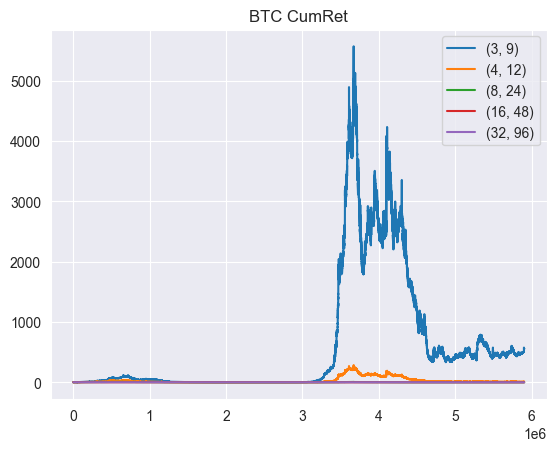

In [110]:
import matplotlib.pyplot as plt
lookback_window = [2,3,4,8,16,32]
for lookback, pnl in zip(lookback_window[1:], res_gross_pnl[1:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("BTC CumRet")

In [87]:
signal_df = get_signal_df(df)
lookback_window = [5, 10, 20, 30, 60, 120, 240, 360, 480]
res_gross_pnl, stats_df = run_backtest(signal_df, lookback_window)

In [88]:
stats_df

,lookback_5,lookback_10,lookback_20,lookback_30,lookback_60,lookback_120,lookback_240,lookback_360,lookback_480
avg_abs_pos,0.4982,0.4940,0.4948,0.4992,0.5136,0.5383,0.5631,0.5773,0.5913
gross_return,18.8114,8.1194,4.0087,1.2287,7.2529,30.0489,38.7019,40.2685,45.1728
net_return,18.8114,8.1194,4.0087,1.2287,7.2529,30.0489,38.7019,40.2685,45.1728
vol,57.8949,57.4161,56.8382,56.3995,55.6263,55.6563,56.0683,58.3546,61.8726
gross_sr,0.3249,0.1414,0.0705,0.0218,0.1304,0.5399,0.6903,0.6901,0.7301
net_sr,0.3249,0.1414,0.0705,0.0218,0.1304,0.5399,0.6903,0.6901,0.7301
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,20553.7635,10011.9416,4920.2119,3250.5477,1610.5798,805.9162,411.5605,284.6696,221.4953
max_dd,-7.2599,-5.4501,-3.0911,-2.2912,-1.8585,-0.6730,-0.6016,-0.7499,-0.8514


Text(0.5, 1.0, 'BTC CumRet')

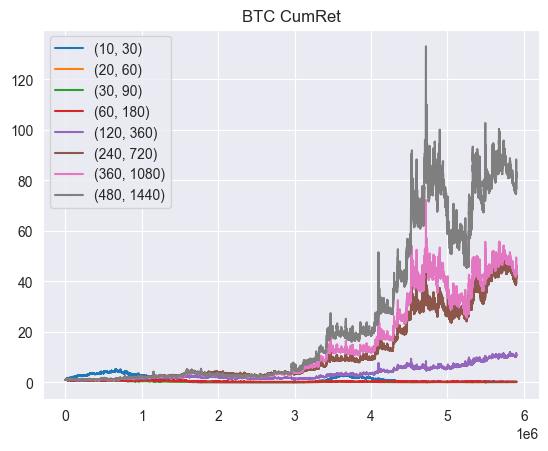

In [89]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window[1:], res_gross_pnl[1:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("BTC CumRet")

In [41]:
signal_df = get_signal_df(df)
lookback_window = [5, 10, 20, 30, 60, 120, 240, 360, 480]
res_gross_pnl, stats_df = run_backtest(signal_df, lookback_window, use_so=False)

In [42]:
stats_df

,lookback_5,lookback_10,lookback_20,lookback_30,lookback_60,lookback_120,lookback_240,lookback_360,lookback_480
avg_abs_pos,0.5023,0.5203,0.5441,0.5576,0.5861,0.6138,0.6375,0.6611,0.6762
gross_return,10.5115,25.3946,36.0970,38.7620,46.3693,51.4385,51.0774,50.8415,49.3616
net_return,10.5115,25.3946,36.0970,38.7620,46.3693,51.4385,51.0774,50.8415,49.3616
vol,57.4552,57.1728,56.9598,57.1159,61.5363,63.4052,64.0692,64.4743,64.4169
gross_sr,0.1830,0.4442,0.6337,0.6787,0.7535,0.8113,0.7972,0.7886,0.7663
net_sr,0.1830,0.4442,0.6337,0.6787,0.7535,0.8113,0.7972,0.7886,0.7663
tc,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
signal_turnover,6269.5308,3044.9561,1491.0670,986.9800,497.7400,256.1987,139.3672,102.9922,85.8163
max_dd,-3.4559,-1.9200,-0.8272,-0.7402,-0.5863,-0.7741,-0.7534,-0.7778,-0.7642


Text(0.5, 1.0, 'BTC CumRet')

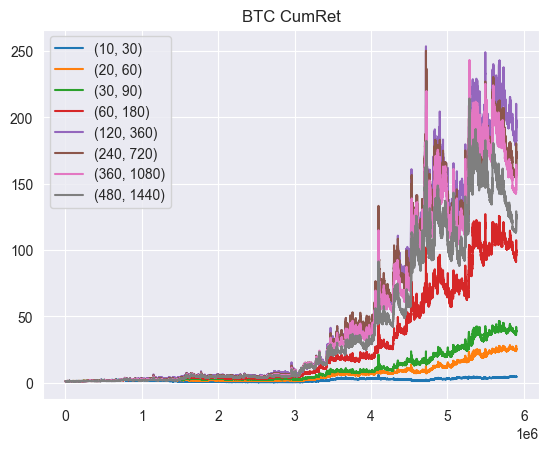

In [43]:
import matplotlib.pyplot as plt
for lookback, pnl in zip(lookback_window[1:], res_gross_pnl[1:]):
    p = (pnl + 1).cumprod().reset_index(drop=True).plot(label=f'({lookback}, {lookback * 3})')
plt.legend(loc="best")
plt.title("BTC CumRet")
